In [5]:
import joblib, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
#  loading it back in 
loaded = joblib.load('Data/movie_reviews_v2.joblib')
df = loaded['df']

In [6]:
highrate= df['rating']>=9
lowrate= df['rating']<=4
df.loc[highrate,'High_Low']='high'
df.loc[lowrate,'High_Low']='low'
df.head()

,movie_id,imdb_id,original_title,review,rating,tokens,lemmas,tokens-joined,lemmas-joined,High_Low
review_id,,,,,,,,,,
57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,"[guilty, pleasure, personally, love, great, es...","[guilty, pleasure, personally, love, great, es...",guilty pleasure personally love great escape w...,guilty pleasure personally love great escape w...,high
57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,"[underwhelmed, straight, bored, course, seeing...","[underwhelme, straight, bore, course, see, hun...",underwhelmed straight bored course seeing hunt...,underwhelme straight bore course see hunt clim...,low
5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,"[entertainign, mission, impossible, second, in...","[entertainign, mission, impossible, second, in...",entertainign mission impossible second install...,entertainign mission impossible second install...,low
608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,"[okay, admit, bit, easy, grader, comes, romant...","[okay, admit, bit, easy, grader, come, romanti...",okay admit bit easy grader comes romantic come...,okay admit bit easy grader come romantic comed...,high
6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,"[scream, 3, lackluster, screenplay, unimaginat...","[scream, 3, lackluster, screenplay, unimaginat...",scream 3 lackluster screenplay unimaginative k...,scream 3 lackluster screenplay unimaginative k...,low


In [7]:
X=df['review']
y=df['High_Low']
y.value_counts(normalize=True)

low     0.508772
high    0.491228
Name: High_Low, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Instansiate label encoder
encoder = LabelEncoder()
# Fit and Transform the strings into integers
y = encoder.fit_transform(y)
# Original Class names saved as .classes_
classes = encoder.classes_
y[:10], len(classes)

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1])

In [17]:
# estimate sequence length
df['length (tokens)'] = df['tokens'].map(len)
df['length (tokens)'].describe()

count    2394.000000
mean      104.807435
std       129.819129
min         1.000000
25%        29.000000
50%        67.000000
75%       130.000000
max      1937.000000
Name: length (tokens), dtype: float64

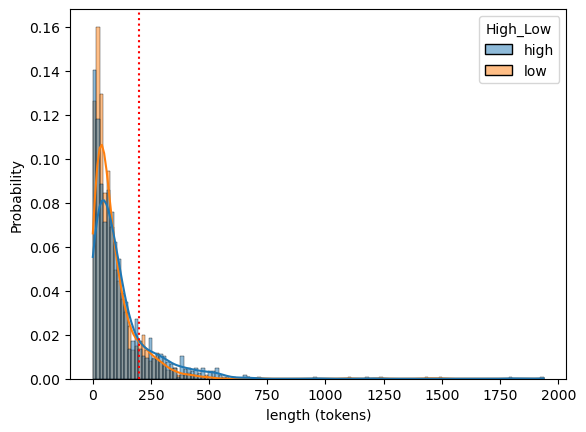

In [19]:
SEQUENCE_LENGTH = 200
ax = sns.histplot(data=df, hue='High_Low', x='length (tokens)', kde=True,
                 stat='probability',common_norm=False)
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":");

In [23]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs
    
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [24]:

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(4,8),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):

    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

## PLOT_HISTORY FUNCTION
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [25]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,6), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)       y_train (array, or None if using a Dataset)
        X_test (array, or Dataset)        y_test (array, or None if using a Dataset)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

# Select a sklearn vectorizer

# Build Machine Learning Models

# GridSearch Text Vectorization

# Create train/test/val datasets

In [9]:
import tensorflow as tf
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
# Then Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [12]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))

# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False) 
# display a sample single element 
example_X, example_y= ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"This film marks the end, the absolute end of Oliver Stone's work.\r\n\r\nAlexander wasn't great, but you still had that Oliver Stone vibe when you watched it. You still knew who was making it.\r\n\r\nWorld Trade Center is Stone directing a Lifetime movie with an enormous budget. It's competently made...but it's doesn't feel like it's Oliver Stone signed sealed, and delivered.\r\n\r\nOnce upon a time you could sit down and watch a movie and knew he directed it without even knowing the title. Now, well, after Alexander, you can tell he had a hand in the script and that's really it.\r\n\r\nWTC doesn't have the mark of Oliver Stone on it and, honestly it sucks because of it.", shape=(), dtype=string) 

 tf.Tensor(1, shape=(), dtype=int32)


In [13]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

# Set the batch size
BATCH_SIZE =32
 
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	1675 samples 	(53 batches)
    - val:  	478 samples 	(15 batches)
    - test: 	241 samples 	(8 batches)


In [14]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)
# Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(53, 15, 8)

In [16]:
_, example_y= train_ds.take(1).get_single_element()
print(example_y)

tf.Tensor([1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0], shape=(32,), dtype=int32)


# Create a Keras Sequence Vectorizer layer

In [20]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH)

sequence_vectorizer.adapt(ds_texts)

In [21]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

24925

In [22]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'and',
 4: 'a',
 5: 'of',
 6: 'to',
 7: 'is',
 8: 'it',
 9: 'in',
 10: 'that',
 11: 'i',
 12: 'this',
 13: 'but',
 14: 'was',
 15: 'for',
 16: 'as',
 17: 'with',
 18: 'movie',
 19: 'film',
 20: 'not',
 21: 'are',
 22: 'its',
 23: 'on',
 24: 'you',
 25: 'be',
 26: 'one',
 27: 'have',
 28: 'his',
 29: 'an',
 30: 'all',
 31: 'so',
 32: 'from',
 33: 'like',
 34: 'he',
 35: 'at',
 36: 'they',
 37: 'by',
 38: 'just',
 39: 'if',
 40: 'about',
 41: 'or',
 42: 'what',
 43: 'there',
 44: 'story',
 45: 'more',
 46: 'has',
 47: 'some',
 48: 'really',
 49: 'who',
 50: 'good',
 51: 'my',
 52: 'out',
 53: 'me',
 54: 'even',
 55: 'very',
 56: 'when',
 57: 'time',
 58: 'no',
 59: 'well',
 60: 'which',
 61: 'we',
 62: 'had',
 63: 'only',
 64: 'much',
 65: 'up',
 66: 'can',
 67: 'would',
 68: 'their',
 69: 'her',
 70: 'because',
 71: 'also',
 72: 'than',
 73: 'were',
 74: 'into',
 75: 'way',
 76: 'most',
 77: 'great',
 78: 'do',
 79: 'movies',
 80: 'been',
 81: 'how',


# Build Deep Sequence Models (RNN)

In [42]:
from tensorflow.keras import layers, models, optimizers, callbacks
tf.keras.backend.clear_session()

def build_rnn_model1():
    EMBED_DIM=150
    model = models.Sequential([
        sequence_vectorizer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
    
    ## Add an LSTM layer with 32 units
    model.add(layers.LSTM(32, return_sequences = True))    
    # Add recurrent_dropout=0.2 to the SimpleRNN 
    model.add(layers.SimpleRNN(16))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate = .003), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model
    
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 150)          3738750   
                                                                 
 lstm (LSTM)                 (None, 200, 32)           23424     
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3,762,975
Trainable params: 3,762,975
Non-trainable params: 0
______________________________________________

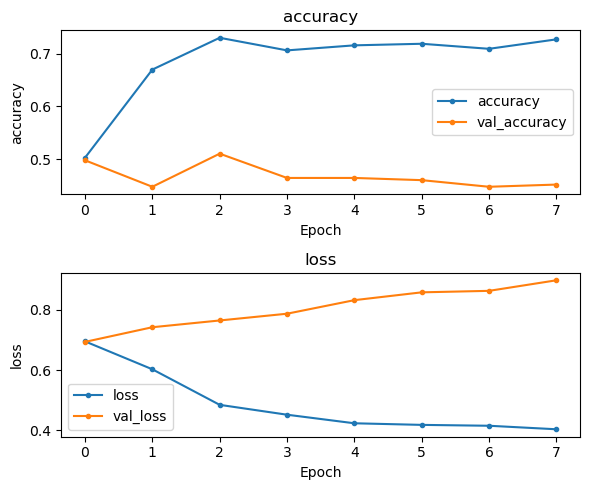

In [43]:
# Build the RNN model 
rnn_model1 = build_rnn_model1()

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model1.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      1.00      0.78       845
           1       1.00      0.41      0.58       830

    accuracy                           0.71      1675
   macro avg       0.82      0.71      0.68      1675
weighted avg       0.82      0.71      0.68      1675



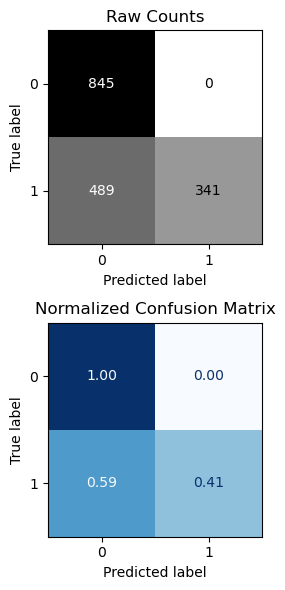


- Evaluating Training Data:
53/53 [==============================] - 2s 35ms/step - loss: 0.4083 - accuracy: 0.7081
{'loss': 0.4083292782306671, 'accuracy': 0.7080597281455994}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.44      0.82      0.57       104
           1       0.60      0.20      0.30       137

    accuracy                           0.47       241
   macro avg       0.52      0.51      0.44       241
weighted avg       0.53      0.47      0.42       241



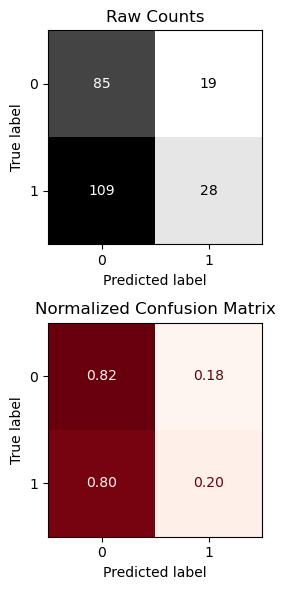


- Evaluating Test Data:
8/8 [==============================] - 0s 33ms/step - loss: 0.8766 - accuracy: 0.4689
{'loss': 0.8766175508499146, 'accuracy': 0.46887966990470886}


In [44]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    rnn_model1, X_train=train_ds, X_test=test_ds);

In [66]:
tf.keras.backend.clear_session()

def build_rnn_model2():
    EMBED_DIM=150
    model = models.Sequential([
        sequence_vectorizer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
    

    model.add(layers.LSTM(64, return_sequences = True))    
    model.add(layers.Dropout(.4))
    model.add(layers.GRU(32, return_sequences = True))
    model.add(layers.Dropout(.2))
    model.add(layers.GlobalMaxPooling1D())
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.Adamax(), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

# Build the RNN model 
rnn_model2 = build_rnn_model2()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 150)          3738750   
                                                                 
 lstm (LSTM)                 (None, 200, 64)           55040     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 gru (GRU)                   (None, 200, 32)           9408      
                                                                 
 dropout_1 (Dropout)         (None, 200, 32)           0         
                                                        

Epoch 1/30
53/53 [==============================] - 16s 243ms/step - loss: 0.6910 - accuracy: 0.5319 - val_loss: 0.6887 - val_accuracy: 0.6192
Epoch 2/30
53/53 [==============================] - 12s 232ms/step - loss: 0.6649 - accuracy: 0.6042 - val_loss: 0.6111 - val_accuracy: 0.6820
Epoch 3/30
53/53 [==============================] - 13s 250ms/step - loss: 0.4777 - accuracy: 0.8096 - val_loss: 0.5275 - val_accuracy: 0.7824
Epoch 4/30
53/53 [==============================] - 13s 240ms/step - loss: 0.3639 - accuracy: 0.8818 - val_loss: 0.5898 - val_accuracy: 0.7657
Epoch 5/30
53/53 [==============================] - 14s 258ms/step - loss: 0.2840 - accuracy: 0.9051 - val_loss: 0.5359 - val_accuracy: 0.7782
Epoch 6/30
53/53 [==============================] - 14s 271ms/step - loss: 0.3341 - accuracy: 0.8937 - val_loss: 0.5173 - val_accuracy: 0.7803
Epoch 7/30
53/53 [==============================] - 17s 319ms/step - loss: 0.3387 - accuracy: 0.8657 - val_loss: 0.5530 - val_accuracy: 0.7259

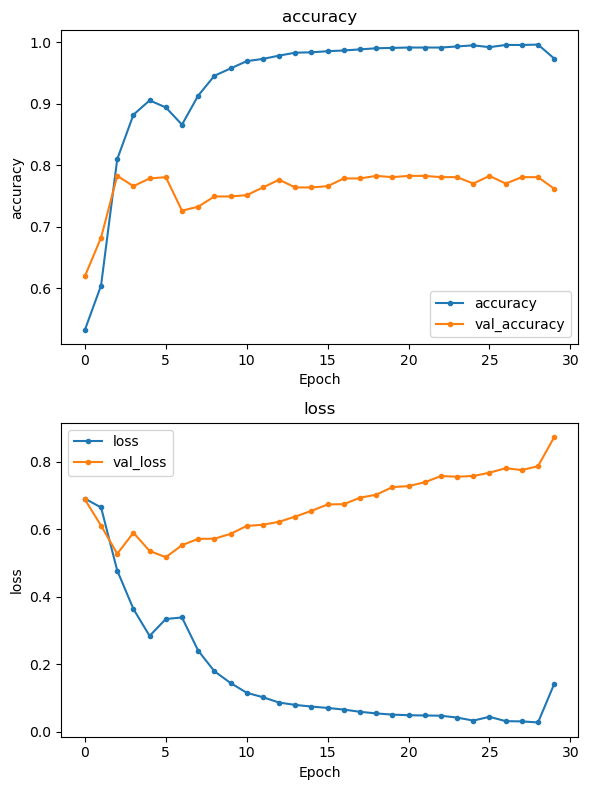

In [67]:
def get_callbacks(patience=3, monitor='accuracy'):
    early_stop = callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]
    
# Fit the model
history = rnn_model2.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       845
           1       0.99      1.00      1.00       830

    accuracy                           1.00      1675
   macro avg       1.00      1.00      1.00      1675
weighted avg       1.00      1.00      1.00      1675



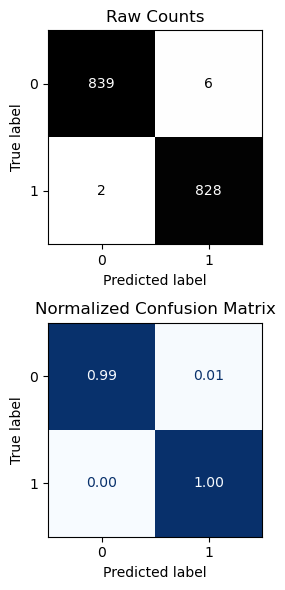


- Evaluating Training Data:
53/53 [==============================] - 3s 56ms/step - loss: 0.0329 - accuracy: 0.9952
{'loss': 0.03285091742873192, 'accuracy': 0.995223879814148}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       104
           1       0.77      0.79      0.78       137

    accuracy                           0.75       241
   macro avg       0.74      0.74      0.74       241
weighted avg       0.75      0.75      0.75       241



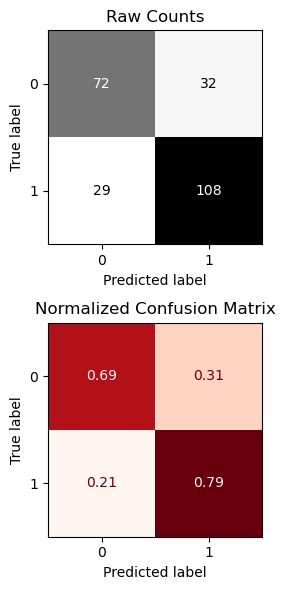


- Evaluating Test Data:
8/8 [==============================] - 0s 51ms/step - loss: 0.8726 - accuracy: 0.7469
{'loss': 0.8726040124893188, 'accuracy': 0.7468879818916321}


In [48]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    rnn_model2, X_train=train_ds, X_test=test_ds);